* [OASIS-1 Dataset](#oasis-1-dataset)<br>
* [Environment Setup and Data Import](#environment-setup-and-data-import)<br>
* [Convoluted Neural Network for Diagnosis](#convoluted-neural-network-for-diagnosis)<br>
* [Visualizing the Input](#visualizing-the-input)<br>
* [Predicting Alzheimer's in Cognitively Normal Subjects](#predicting-alzheimers-in-cognitively-normal-subjects)

# OASIS-1
___

**Summary:** This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.
<br><br>
For analysis, AD patients were upsampled to balance the dataset.
<br><br>
### Diagnosis Labeling<br>
___
Clinical Dementia Ratings (CDR) are provided in the dataset with the following attributions:
> 0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD<br>

For the purpose of analysis, all patients with a CDR of 0 are giving a diagnosis of 0, denoting cognitively healthy. CDR ratings above 0 are converted to 1, for an AD diagnosis, and binary classification.

```python
diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' }
```

### MRI Images<br>
___
This study uses transverse orientation cuts taken from a three-dimensional MRI stack. The images have been altered with a mask such that each voxel is assigned a value between 0 and 5.

# Environment Setup and Data Import

In [1]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from ann_visualizer.visualize import ann_viz;
from sklearn.tree import export_graphviz
import graphviz

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose

import nibabel as nib
from nibabel.testing import data_path

from PIL import Image

import nilearn
from nilearn import image, plotting

import ggplot
from ggplot import aes, geom_point, ggtitle

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for mo

In [2]:
def get_slice(): # read in OASIS-1 MRI data across discs
    
    path = '/Users/glynismattheisen/Desktop/Final/Discs'
    disc_list = os.listdir(path) # get list of discs from directory
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4,path_n3, path_n6,path_n5]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [3]:
disc_list, brain_list, total_subjects = get_slice()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/FSL_SEG/OAS1_0448_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/FSL_SEG/OAS1_0449_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/FSL_SEG/OAS1_0439_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/gly

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc1/OAS1_0020_MR1/FSL_SEG/OAS1_0020_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc1/OAS1_0034_MR1/FSL_SEG/OAS1_0034_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc1/OAS1_0009_MR1/FSL_SEG/OAS1_0009_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0070_MR1/FSL_SEG/OAS1_0070_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0064_MR1/FSL_SEG/OAS1_0064_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0065_MR1/FSL_SEG/OAS1_0065_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

In [4]:
def get_subject(filename): # parse out subject IDs from filenames
    return filename[0:9]

In [175]:
def get_diagnosis(total_subjects): # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('/Users/glynismattheisen/Desktop/Final2/oasis_cross-sectional.csv') # read in summary file
    oasis1['CDR'].fillna(0, inplace=True) # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' } # convert to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'AD':1} # convert back to numbers
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    
    subjects = [] # get subject names for each MRI ID
    for subj_id in total_subjects:
        subjects.append(get_subject(subj_id))
        
    subjects = pd.DataFrame(subjects, columns = ['Subject']) # convert to dataframe
    oasis1['Subject'] =oasis1['ID'].apply(get_subject) # extract subject ID from MR ID
    
    diagnosis_dict= {} # create a dictionary with subject and diagnosis
    for num in range(0,436):
        diagnosis_dict[oasis1['Subject'][num]] = oasis1['CDR'][num]
        
    diag = [] # create a list of diagnoses to append to dataframe of subjects
    for subj in subjects['Subject']:
        diag.append(diagnosis_dict[subj])

    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects, diagnosis_dict

In [176]:
subjects, diagnosis_dict = get_diagnosis(total_subjects)

In [7]:
def balance_set(subjects, total_subjects, disc_list): # make a list of 236 AD patients to balance data
    AD_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as AD
    AD_subjects = AD_subjects.append(AD_subjects)
    head = AD_subjects.head(42)
    AD_subjects = AD_subjects.append(head)    
    
    for subj in AD_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'/Users/glynismattheisen/Desktop/Final/Discs/{disc}'

            for i in AD_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4,path_n3, path_n6,path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, AD_subjects

In [177]:
brain_array, AD_subjects = balance_set(subjects, total_subjects, disc_list)
subjects, diagnosis_dict = get_diagnosis(total_subjects)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0440_MR1/FSL_SEG/OAS1_0440_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0454_MR1/FSL_SEG/OAS1_0454_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0441_MR1/FSL_SEG/OAS1_0441_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0067_MR1/FSL_SEG/OAS1_0067_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0060_MR1/FSL_SEG/OAS1_0060_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0073_MR1/FSL_SEG/OAS1_0073_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Use

In [9]:
brain_array # array of MRI images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [10]:
subjects.head(5) # dataframe of subjects and their diagnosis

,Subject,Diagnosis
0,OAS1_0448,0
1,OAS1_0449,0
2,OAS1_0439,0
3,OAS1_0438,0
4,OAS1_0428,0


# Convoluted Neural Network for Diagnosis
___

In [11]:
x_MRI = brain_array # array of image values
y_MRI = np.asarray(subjects['Diagnosis']) # diagnosis for each subject
x_MRI = x_MRI.reshape(-1, 208, 176,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_MRI_norm = norm(x_MRI)

assert (np.min(x_MRI_norm), np.max(x_MRI_norm)) == (0.0, 1.0) # check min and max values
x_MRI_train, x_MRI_test, y_MRI_train, y_MRI_test = train_test_split(x_MRI_norm,y_MRI, random_state = 42)

In [17]:
input_shape = (208,176,1)

model = Sequential()
model.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                 activation='sigmoid', padding ='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
model.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

EarlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto') # stop when loss no longer improving

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_MRI_train, y_MRI_train, epochs=500, batch_size=75, callbacks=[EarlyStopping])

Epoch 1/500
499/499 [==============================] - 1s 1ms/step - loss: 0.6947 - acc: 0.4870
Epoch 2/500
499/499 [==============================] - 0s 537us/step - loss: 0.6955 - acc: 0.4950
Epoch 3/500
499/499 [==============================] - 0s 540us/step - loss: 0.6949 - acc: 0.4830
Epoch 4/500
499/499 [==============================] - 0s 511us/step - loss: 0.6941 - acc: 0.4749
Epoch 5/500
499/499 [==============================] - 0s 510us/step - loss: 0.6932 - acc: 0.4930
Epoch 6/500
499/499 [==============================] - 0s 506us/step - loss: 0.6937 - acc: 0.4729
Epoch 7/500
499/499 [==============================] - 0s 509us/step - loss: 0.6934 - acc: 0.5010
Epoch 8/500
499/499 [==============================] - 0s 509us/step - loss: 0.6927 - acc: 0.4910
Epoch 9/500
499/499 [==============================] - 0s 503us/step - loss: 0.6933 - acc: 0.4990
Epoch 10/500
499/499 [==============================] - 0s 503us/step - loss: 0.6933 - acc: 0.4990
Epoch 11/500
499/499 

499/499 [==============================] - 0s 537us/step - loss: 0.4319 - acc: 0.8116
Epoch 84/500
499/499 [==============================] - 0s 500us/step - loss: 0.4194 - acc: 0.8196
Epoch 85/500
499/499 [==============================] - 0s 509us/step - loss: 0.4179 - acc: 0.8216
Epoch 86/500
499/499 [==============================] - 0s 501us/step - loss: 0.4197 - acc: 0.8176
Epoch 87/500
499/499 [==============================] - 0s 583us/step - loss: 0.4149 - acc: 0.8196
Epoch 88/500
499/499 [==============================] - 0s 557us/step - loss: 0.4116 - acc: 0.8096
Epoch 89/500
499/499 [==============================] - 0s 580us/step - loss: 0.4137 - acc: 0.8257
Epoch 90/500
499/499 [==============================] - 0s 580us/step - loss: 0.4109 - acc: 0.8196
Epoch 91/500
499/499 [==============================] - 0s 563us/step - loss: 0.4126 - acc: 0.8236
Epoch 92/500
499/499 [==============================] - 0s 556us/step - loss: 0.4104 - acc: 0.8216
Epoch 93/500
499/499 [=

499/499 [==============================] - 0s 589us/step - loss: 0.3799 - acc: 0.8377
Epoch 166/500
499/499 [==============================] - 0s 520us/step - loss: 0.3712 - acc: 0.8437
Epoch 167/500
499/499 [==============================] - 0s 494us/step - loss: 0.3733 - acc: 0.8417
Epoch 168/500
499/499 [==============================] - 0s 532us/step - loss: 0.3709 - acc: 0.8417
Epoch 169/500
499/499 [==============================] - 0s 578us/step - loss: 0.3694 - acc: 0.8517
Epoch 170/500
499/499 [==============================] - 0s 580us/step - loss: 0.3880 - acc: 0.8397
Epoch 171/500
499/499 [==============================] - 0s 554us/step - loss: 0.3706 - acc: 0.8477
Epoch 172/500
499/499 [==============================] - 0s 509us/step - loss: 0.3908 - acc: 0.8337
Epoch 173/500
499/499 [==============================] - 0s 514us/step - loss: 0.3721 - acc: 0.8437
Epoch 174/500
499/499 [==============================] - 0s 562us/step - loss: 0.3699 - acc: 0.8477
Epoch 175/500


In [19]:
def get_metrics(model, x_test, y_test): # get accuracy, recall, precision
    results = model.evaluate(x_test, y_test)
    accuracy = round(results[1]*100,2)
    y_pred = model.predict_classes(x_test) # predictions for test set
    recall = round((recall_score(y_test, y_pred))*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    return accuracy, recall, precision

In [20]:
model_accuracy, model_recall, model_precision = get_metrics(model, x_MRI_test, y_MRI_test)

167/167 [==============================] - 0s 993us/step


In [23]:
ann_viz(model, title="Neural Network for MRI Classification"); # visualize CNN

/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16920 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16922 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16925 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16927 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16929 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16931 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 16933

# Visualize the Input
___

                                  Test Images                                   


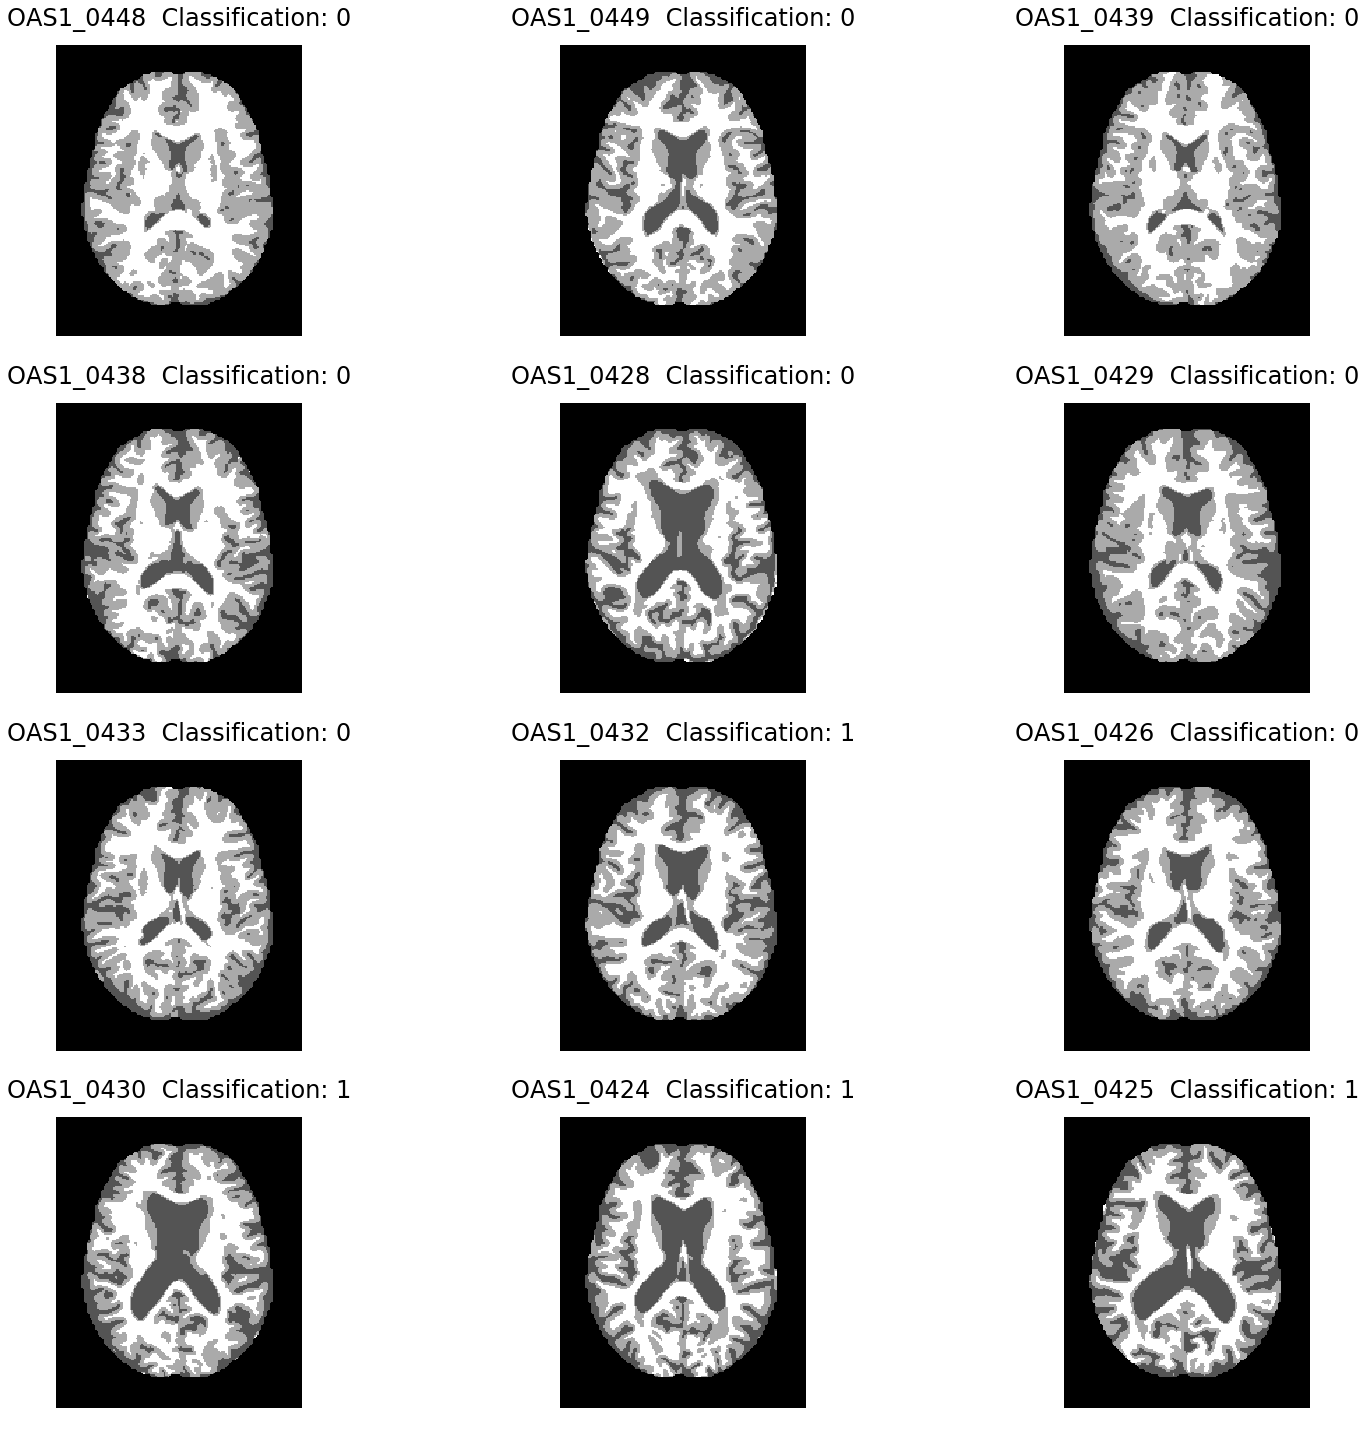

In [24]:
def plot_test_images(subject, diagnosis, array):
    plt.figure(figsize = (20, 20))
    print("Test Images".center(os.get_terminal_size().columns))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap = 'gray')
        plt.subplots_adjust(wspace = 0.25)
    plt.show()  
    
plot_test_images(subjects['Subject'], subjects['Diagnosis'], brain_array)

# t-SNE Dimensionality Reduction

In [26]:
x_MRI = x_MRI[:,:,:,0]
tsne = TSNE(n_components=2, init='pca', random_state=42) # initialize t-SNE
assert x_MRI.shape == (666, 208, 176) # check shape
x_tsne = tsne.fit_transform(x_MRI.reshape((666,208*176))) # fit data

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [28]:
def run_tsne(x_tsne, y_MRI):
    x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test = train_test_split(x_tsne,y_MRI, random_state = 42)
    he = keras.initializers.he_normal(seed=42)   
    model_tsne = Sequential([
    Dense(50, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(20),
    Activation('sigmoid'),
    Dense(10),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
    model_tsne.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model_tsne, x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test, tsne

model_tsne, x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test, tsne= run_tsne(x_tsne,y_MRI)

In [29]:
model_tsne.fit(x_tsne_train, y_tsne_train, epochs=500, batch_size=50, callbacks=[EarlyStopping])

Epoch 1/100
499/499 [==============================] - 0s 997us/step - loss: 0.6287 - acc: 0.7134
Epoch 2/100
499/499 [==============================] - 0s 37us/step - loss: 0.5168 - acc: 0.8136
Epoch 3/100
499/499 [==============================] - 0s 31us/step - loss: 0.4630 - acc: 0.8136
Epoch 4/100
499/499 [==============================] - 0s 39us/step - loss: 0.4446 - acc: 0.8156
Epoch 5/100
499/499 [==============================] - 0s 38us/step - loss: 0.4274 - acc: 0.8257
Epoch 6/100
499/499 [==============================] - 0s 52us/step - loss: 0.4169 - acc: 0.8357
Epoch 7/100
499/499 [==============================] - 0s 36us/step - loss: 0.4129 - acc: 0.8357
Epoch 8/100
499/499 [==============================] - 0s 37us/step - loss: 0.4110 - acc: 0.8357
Epoch 9/100
499/499 [==============================] - 0s 29us/step - loss: 0.4085 - acc: 0.8357
Epoch 10/100
499/499 [==============================] - 0s 41us/step - loss: 0.4040 - acc: 0.8357
Epoch 11/100
499/499 [======

499/499 [==============================] - 0s 38us/step - loss: 0.3650 - acc: 0.8457
Epoch 85/100
499/499 [==============================] - 0s 31us/step - loss: 0.3703 - acc: 0.8477
Epoch 86/100
499/499 [==============================] - 0s 33us/step - loss: 0.3734 - acc: 0.8457
Epoch 87/100
499/499 [==============================] - 0s 38us/step - loss: 0.3685 - acc: 0.8517
Epoch 88/100
499/499 [==============================] - 0s 28us/step - loss: 0.3625 - acc: 0.8517
Epoch 89/100
499/499 [==============================] - 0s 32us/step - loss: 0.3632 - acc: 0.8457
Epoch 90/100
499/499 [==============================] - 0s 33us/step - loss: 0.3659 - acc: 0.8497
Epoch 91/100
499/499 [==============================] - 0s 41us/step - loss: 0.3651 - acc: 0.8517
Epoch 92/100
499/499 [==============================] - 0s 35us/step - loss: 0.3624 - acc: 0.8517
Epoch 93/100
499/499 [==============================] - 0s 34us/step - loss: 0.3628 - acc: 0.8477
Epoch 94/100
499/499 [===========

In [30]:
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_tsne, x_tsne_test, y_tsne_test)

167/167 [==============================] - 0s 787us/step


# Visualize the t-SNE

<Figure size 432x288 with 0 Axes>

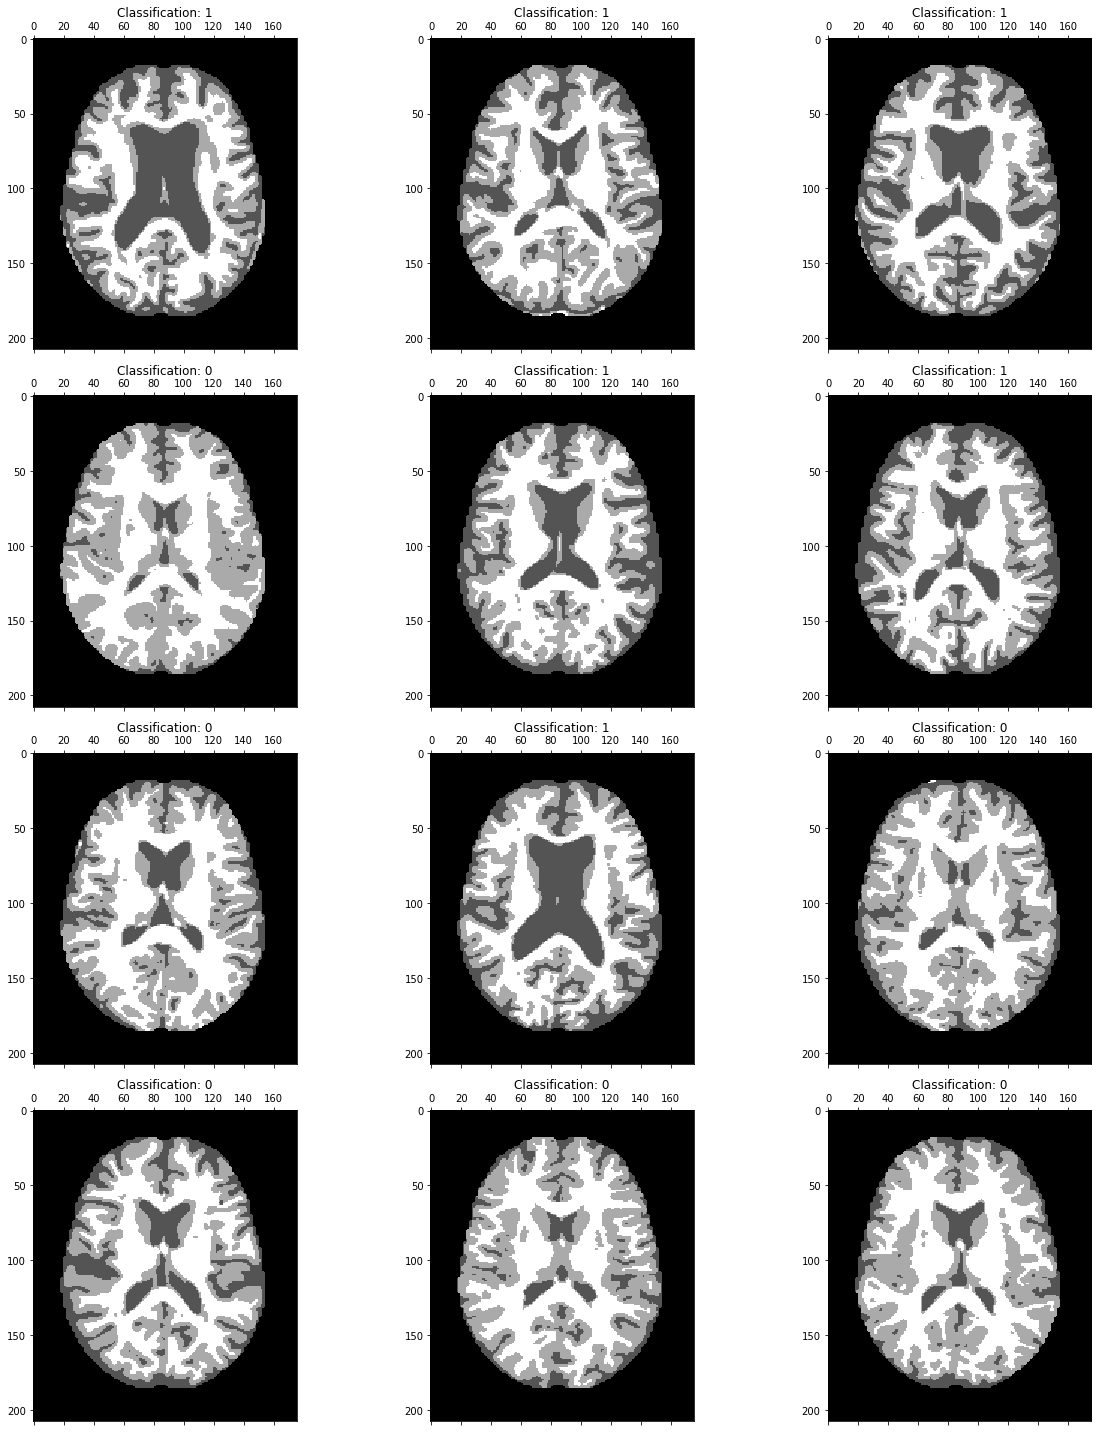

In [31]:
x = x_MRI.reshape((666,208*176))
feat_cols = ['pixel'+str(i) for i in range(x.shape[1])] # name each column a pixel number
df = pd.DataFrame(x, columns=feat_cols) # convert X to dataframe
df['label'] = y_MRI
df['label'] = df['label'].apply(lambda i: str(i)) 
rndperm = np.random.permutation(df.shape[0])

plt.gray()
fig = plt.figure(figsize = (20,20))
for i in range(0,12):
    ax = fig.add_subplot(4, 3, i+1, title='Classification: ' + str(df.loc[rndperm[i], 'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
    plt.tight_layout()
plt.show()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


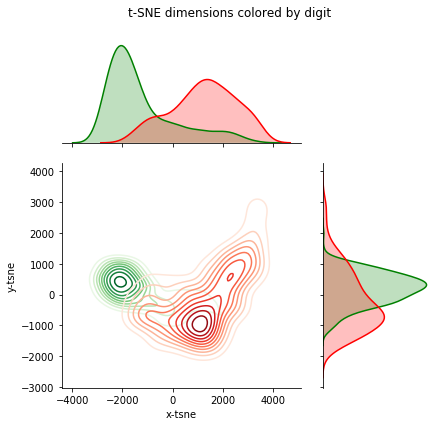

In [43]:
healthy = df_tsne.loc[df.label == "0"]
AD = df_tsne.loc[df.label == "1"]
g = sns.JointGrid(x="x-tsne", y="y-tsne", data=df_tsne, ratio = 2)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('t-SNE dimensions colored by digit')
sns.kdeplot(healthy['x-tsne'], healthy['y-tsne'], cmap="Greens",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(AD['x-tsne'], AD['y-tsne'], cmap="Reds",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(healthy['x-tsne'], color="g", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(AD['x-tsne'], color="r", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(healthy['y-tsne'], color="g", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
sns.kdeplot(AD['y-tsne'], color="r", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
plt.show()

# PCA

In [45]:
m_PCA = PCA(n_components=10)
m_PCA.fit(x)
xt = m_PCA.transform(x)
xback = m_PCA.inverse_transform(xt)
assert x.shape == xback.shape
xback = xback.reshape((666,208,176))

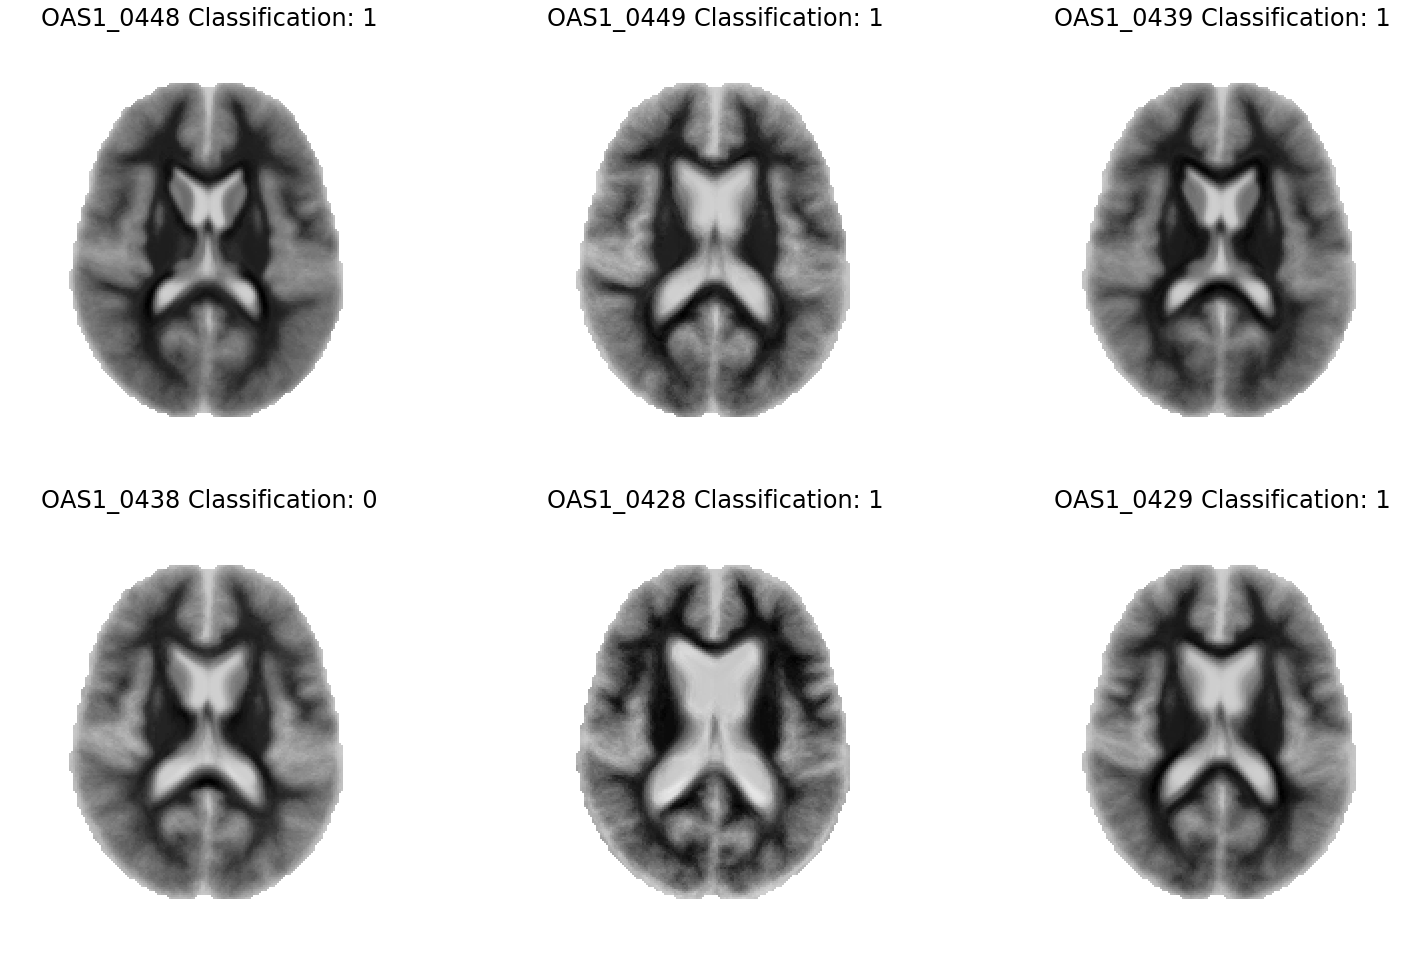

In [49]:
def draw(subject, input):
    plt.figure(figsize=(20,20))

    for i in range(6):
        plt.subplot(3, 3, i+1)
        plt.title(str(subject[i]) + ' Classification: ' + str(df.loc[rndperm[i],'label']), fontsize=24, pad = 20)
        plt.imshow(input[i], cmap=plt.cm.Greys)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.25)
        plt.axis('off')
    plt.show()
    
draw(subjects['Subject'], xback)

In [51]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(xt,y_MRI, random_state = 42)

he = keras.initializers.he_normal(seed=42)    

model_PCA = Sequential([
Dense(100, input_shape=(10,), kernel_initializer=he),
Activation('sigmoid'),
Dense(30),
Activation('sigmoid'),
Dense(15),
Activation('sigmoid'),
Dense(1),
Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_PCA.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [52]:
model_PCA.fit(X_PCA_train,y_PCA_train,epochs=500, batch_size=50, callbacks=[EarlyStopping])

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 1ms/step - loss: 0.6110 - acc: 0.7519 - val_loss: 0.4589 - val_acc: 0.8600
Epoch 2/100
399/399 [==============================] - 0s 35us/step - loss: 0.4555 - acc: 0.8170 - val_loss: 0.3514 - val_acc: 0.8700
Epoch 3/100
399/399 [==============================] - 0s 36us/step - loss: 0.3939 - acc: 0.8471 - val_loss: 0.3253 - val_acc: 0.8700
Epoch 4/100
399/399 [==============================] - 0s 48us/step - loss: 0.3540 - acc: 0.8747 - val_loss: 0.3029 - val_acc: 0.8900
Epoch 5/100
399/399 [==============================] - 0s 41us/step - loss: 0.3309 - acc: 0.8747 - val_loss: 0.2948 - val_acc: 0.8700
Epoch 6/100
399/399 [==============================] - 0s 45us/step - loss: 0.3263 - acc: 0.8747 - val_loss: 0.2903 - val_acc: 0.8700
Epoch 7/100
399/399 [==============================] - 0s 60us/step - loss: 0.3157 - acc: 0.8797 - val_loss: 0.2760 - val_acc: 0.8900
Epoch 8/100
399/3

399/399 [==============================] - 0s 40us/step - loss: 0.0198 - acc: 0.9975 - val_loss: 0.3517 - val_acc: 0.9000
Epoch 62/100
399/399 [==============================] - 0s 40us/step - loss: 0.0201 - acc: 0.9975 - val_loss: 0.3621 - val_acc: 0.9000
Epoch 63/100
399/399 [==============================] - 0s 46us/step - loss: 0.0192 - acc: 0.9975 - val_loss: 0.3628 - val_acc: 0.9000
Epoch 64/100
399/399 [==============================] - 0s 40us/step - loss: 0.0188 - acc: 0.9975 - val_loss: 0.3787 - val_acc: 0.9000
Epoch 65/100
399/399 [==============================] - 0s 32us/step - loss: 0.0183 - acc: 0.9975 - val_loss: 0.3667 - val_acc: 0.9000
Epoch 66/100
399/399 [==============================] - 0s 43us/step - loss: 0.0171 - acc: 0.9975 - val_loss: 0.3725 - val_acc: 0.9000
Epoch 67/100
399/399 [==============================] - 0s 46us/step - loss: 0.0160 - acc: 0.9975 - val_loss: 0.3810 - val_acc: 0.9000
Epoch 68/100
399/399 [==============================] - 0s 39us/step

In [53]:
PCA_accuracy, PCA_recall, PCA_precision = get_metrics(model_PCA,X_PCA_test, y_PCA_test)

167/167 [==============================] - 0s 33us/step


# OASIS-1 Demographic Data and Derived Anatomical Measures
___

In [217]:
df = pd.read_csv('oasis1_cross-sectional.csv') # read in data
df['Subject'] =df['ID'].apply(get_subject) # extract subject ID from MR ID
del df['ID'] # delete MRI ID in favor of Subject ID
del df['Hand'] # delete handedness
del df['Delay'] # delete MRI delay

In [218]:
df_demo = df[['Subject','M/F','Educ','SES','CDR','nWBV']].copy() # new dataframe containing variables to test

In [219]:
# Identify percentage of each categories composed of missing values
total = df_demo.isnull().sum().sort_values(ascending=False)
percent = df_demo.isnull().sum()/df_demo.isnull().count()*100
pd.concat([total, percent], axis=1, keys=['Total', '%'],sort=True)

,Total,%
CDR,199,46.279070
Educ,199,46.279070
M/F,0,0.000000
SES,218,50.697674
Subject,0,0.000000
nWBV,0,0.000000


In [220]:
df_demo['CDR'].fillna(0, inplace=True) # replace empty entries with 0 for cognitively normal
df_demo['CDR'].replace({0.5:1}, inplace=True) # replace 0.5 CDR values with 1 for AD diagnosis
df_demo['CDR'].replace({2:1}, inplace=True) # replace 2 CDR values with 1 for AD diagnosis

In [221]:
def replace_null(column): # fill null values with MEAN +/- STD
    mean = column.mean()
    std = column.std()
    is_null = column.isnull().sum()
    rand_VAR = np.random.randint(mean - std, mean + std, size = is_null)
    VAR_slice = column.copy()
    VAR_slice[np.isnan(VAR_slice)] = rand_VAR
    column = VAR_slice
    column = column.astype(int)
    return column

In [222]:
df_demo['Educ'] = replace_null(df_demo['Educ']) # fill missing Educ value with mean +/- SES
assert df_demo['Educ'].isnull().sum() == 0
df_demo['SES'] = replace_null(df_demo['SES']) # fill missing SES value with mean +/- SES
assert df_demo['SES'].isnull().sum() == 0

genders = {"M": 0, "F": 1}
df_demo['M/F'] = df_demo['M/F'].map(genders) # replace male = 0 and female = 1

In [223]:
temp_df = pd.DataFrame() 
for i in AD_subjects['Subject']: # upsample AD patients to balance set
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) # moving the contents of newly created dataframe to the temporary dataframe
    
total_df = df_demo.append(temp_df) # upsample AD patients to balance set
total_df.corr(method= 'pearson') # look at correlations within dataset

,M/F,Educ,SES,CDR,nWBV
M/F,1.000000,-0.040410,0.102827,-0.021560,-0.012006
Educ,-0.040410,1.000000,-0.352923,0.104979,-0.185719
SES,0.102827,-0.352923,1.000000,0.292297,-0.366844
CDR,-0.021560,0.104979,0.292297,1.000000,-0.722294
nWBV,-0.012006,-0.185719,-0.366844,-0.722294,1.000000


In [224]:
del total_df['M/F'] # delete weakly correlated variable
del total_df['Educ'] # delete weakly correlated variable

total_df.set_index('Subject',inplace=True)

x_text = total_df.drop("CDR", axis=1)
y_text = total_df["CDR"]

assert x_text.shape == (666, 2)
assert y_text.shape == (666,)


# Prediction with Random Forest Classifier

In [139]:
x_text_train, x_text_test, y_text_train, y_text_test = train_test_split(x_text, y_text, random_state = 42)

RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(x_text_train, y_text_train)
print ("Training score: " + str(round(RanFor.score(x_text_train, y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(x_text_test,y_text_test)*100,2)) + '%')

Training score: 86.97%
Test score: 88.02%


In [140]:
random_trees, random_depths =  random.sample(range(1,20),10), random.sample(range(1,50),25)

In [141]:
grid = GridSearchCV(RanFor, 
        param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(x_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 89.98% {'max_depth': 28, 'n_estimators': 12}


In [142]:
final_model = grid.best_estimator_
final_model.fit(x_text_train, y_text_train)

print ("Training score: " + str(final_model.score(x_text_train, y_text_train)))
print ("Test score: " + str(final_model.score(x_text_test, y_text_test)))

Training score: 0.9759519038076152
Test score: 0.8862275449101796


In [97]:
RF_text_accuracy = round(final_model.score(x_text_test,y_text_test)*100,2)
text_pred = final_model.predict(x_text_test)
RF_text_recall = round((recall_score(y_text_test, txt_pred))*100, 2)
RF_text_precision = round(precision_score(y_text_test, txt_pred)*100, 2)

# Oasis 1 Freesurfer Data
___

In [225]:
df_free = pd.read_csv('oasis1_FS.csv') # read in freesurfer data

del df_free['FS_ASEGREGIONANALYSIS ID']
del df_free['MR ID']
del df_free['BrainMaskVol'] # delete redundant data
del df_free['BrainSegNVox'] # delete redundant data

diag = [] # create a list of diagnoses to append to freesurfer dataframe
for subj in df_free['Subject']:
    diag.append(diagnosis_dict[subj])

df_free['Diagnosis'] = pd.DataFrame(diag) # add diagnosis to subjects

In [226]:
norm_to_ICV = lambda x : x / df_free['ICV'] # normalize to intracranial volume

df_free['BrainMaskNVox'] = norm_to_ICV(df_free['BrainMaskNVox'])
df_free['BrainSegVol'] = norm_to_ICV(df_free['BrainSegVol'])

In [231]:
df_free.set_index('Subject', inplace=True)
df_demo.set_index('Subject', inplace=True)

merge = df_free.merge(df_demo, how='inner',left_index=True, right_index=True)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Diagnosis and nWBV')

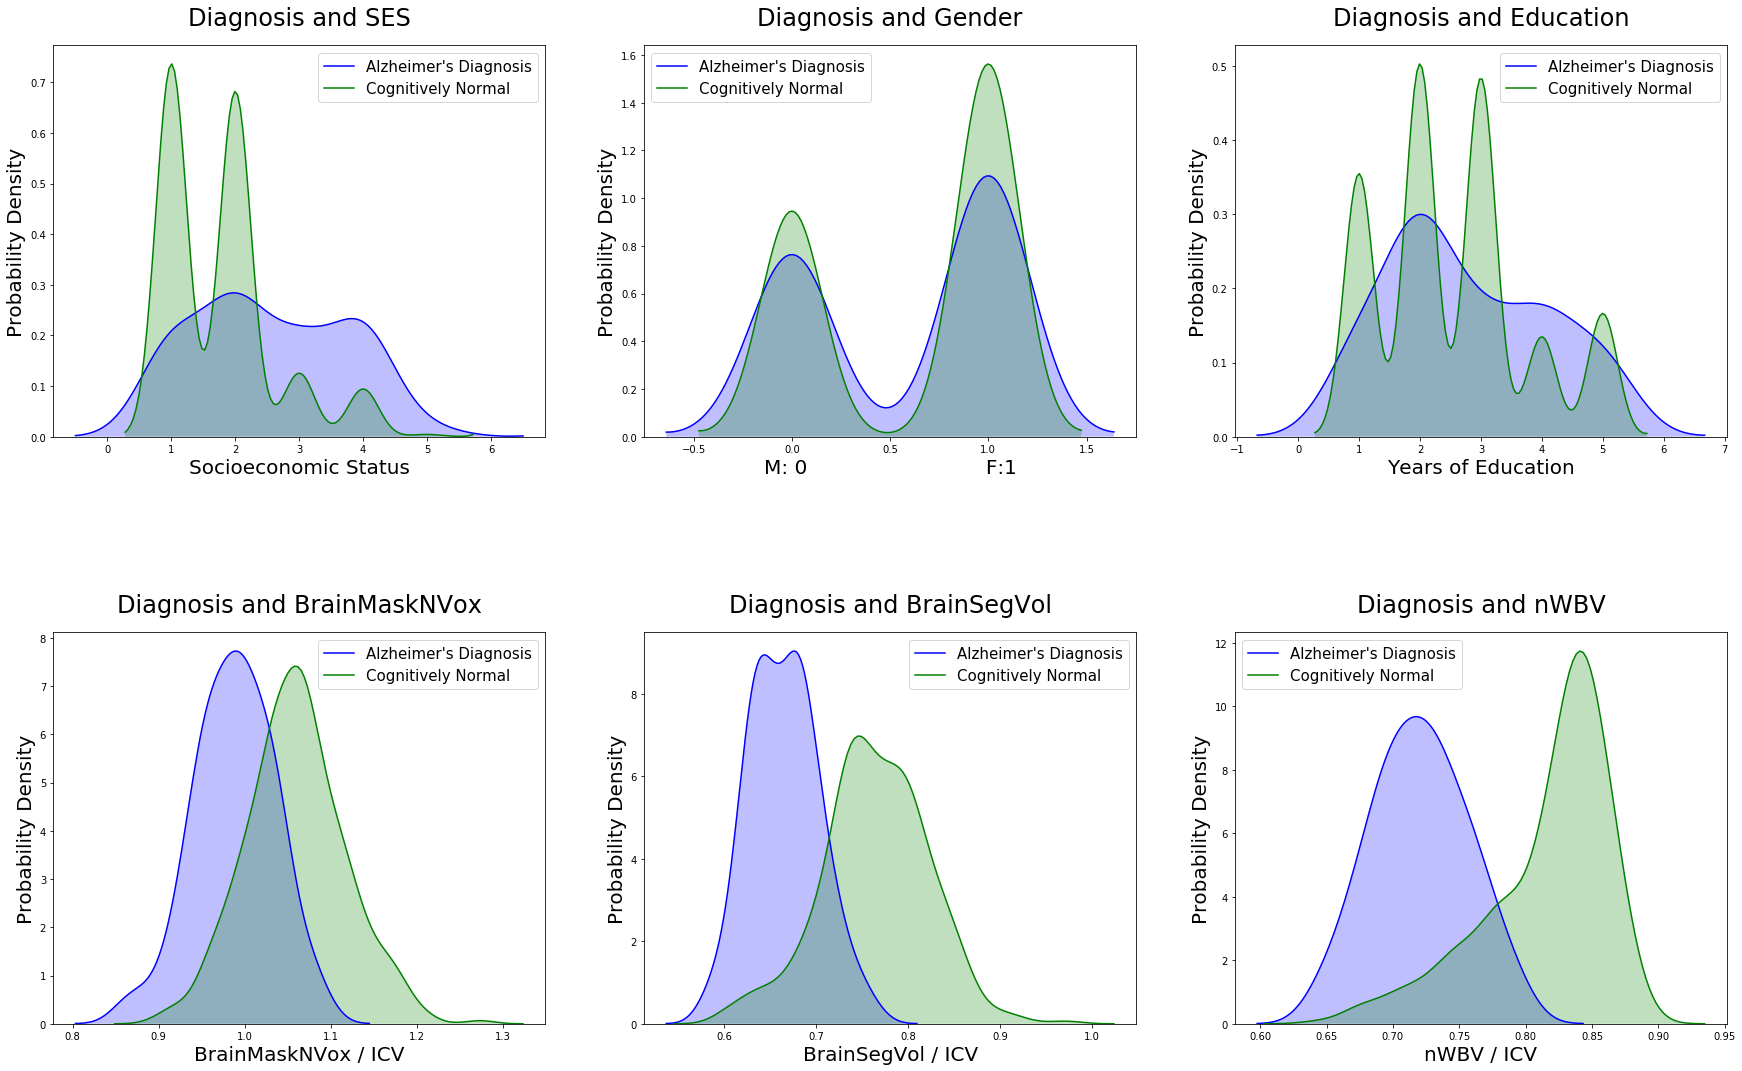

In [238]:
healthy = 'Cognitively Normal'
dementia = 'Alzheimer\'s Diagnosis'

fig = plt.figure(figsize=(30, 18))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.5)

plt.subplot(grid[0, 0])
ax = sns.kdeplot(merge[merge['Diagnosis']==1.0].SES, label = dementia, color='blue', shade=True)
ax = sns.kdeplot(merge[merge['Diagnosis']==0.0].SES, label = healthy, color ='green', shade=True)
ax.legend(fontsize=15)
plt.xlabel('Socioeconomic Status', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.set_title('Diagnosis and SES', fontsize=24, pad = 20)

plt.subplot(grid[0, 1])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0]['M/F'], label = dementia, color='blue', shade=True)
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0]['M/F'], label = healthy, color='green', shade=True)
ax1.legend(fontsize=15)
plt.xlabel('M: 0                            F:1', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.set_title('Diagnosis and Gender', fontsize=24, pad = 20)

plt.subplot(grid[0, 2])
ax2 = sns.kdeplot(merge[merge['Diagnosis']==1.0]['Educ'], label = dementia, color='blue', shade=True)
ax2 = sns.kdeplot(merge[merge['Diagnosis']==0.0]['Educ'], label = healthy, color='green', shade=True)
ax2.legend(fontsize=15)
plt.xlabel('Years of Education', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax2.set_title('Diagnosis and Education', fontsize=24, pad = 20)


plt.subplot(grid[1, 0])
ax = sns.kdeplot(merge[merge['Diagnosis']==1.0].BrainMaskNVox, label = dementia, shade=True, color='blue')
ax = sns.kdeplot(merge[merge['Diagnosis']==0.0].BrainMaskNVox, label = healthy, shade=True, color ='green')
plt.xlabel('BrainMaskNVox / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.legend(fontsize=15)
ax.set_title('Diagnosis and BrainMaskNVox', fontsize=24, pad = 20)

plt.subplot(grid[1, 1])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0].BrainSegVol, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0].BrainSegVol, label = healthy, shade=True,color='green')
plt.xlabel('BrainSegVol / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and BrainSegVol', fontsize=24, pad = 20)

plt.subplot(grid[1, 2])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0].nWBV, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0].nWBV, label = healthy, shade=True,color='green')
plt.xlabel('nWBV / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and nWBV', fontsize=24, pad = 20)

In [241]:
del merge['CDR']
del merge['ICV']

In [242]:
merge.corr()

In [244]:
healthy = merge[merge['Diagnosis'] ==0]
AD = merge[merge['Diagnosis'] ==1]
healthy.describe() # look at values descriptive of healthy patients

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,366.000000,366.000000,366.0,366.000000,366.000000,366.000000,366.000000
mean,1.059237,0.764235,0.0,0.622951,2.546448,1.751366,0.816041
std,0.057157,0.057601,0.0,0.485311,1.205820,0.847841,0.047084
min,0.898880,0.598557,0.0,0.000000,1.000000,1.000000,0.645000
25%,1.023978,0.731177,0.0,0.000000,2.000000,1.000000,0.790000
50%,1.059949,0.767107,0.0,1.000000,2.000000,2.000000,0.832000
75%,1.093218,0.803540,0.0,1.000000,3.000000,2.000000,0.848000
max,1.273024,0.971192,0.0,1.000000,5.000000,5.000000,0.893000


In [245]:
AD.describe() # look at values descriptive of AD patients

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,90.000000,90.000000,90.0,90.000000,90.000000,90.000000,90.000000
mean,0.987884,0.665273,1.0,0.588889,2.788889,2.555556,0.720322
std,0.046183,0.036979,0.0,0.494792,1.293844,1.162244,0.035844
min,0.862992,0.585271,1.0,0.000000,1.000000,1.000000,0.644000
25%,0.954502,0.637523,1.0,0.000000,2.000000,2.000000,0.694000
50%,0.990088,0.665270,1.0,1.000000,2.000000,2.000000,0.720000
75%,1.024725,0.687975,1.0,1.000000,4.000000,4.000000,0.745000
max,1.084934,0.761927,1.0,1.000000,5.000000,5.000000,0.797000


In [266]:
Counter(merge['Diagnosis']) # balance the dataset

Counter({0: 366, 1: 90})

In [279]:
merge_AD = merge.sort_values(by='Diagnosis', ascending=False).head(90)
merge_AD_short = merge.sort_values(by='Diagnosis', ascending=False).head(6)

In [280]:
merge = merge.append(merge_AD)
merge = merge.append(merge_AD)
merge = merge.append(merge_AD)
merge = merge.append(merge_AD_short)

In [281]:
Counter(merge['Diagnosis']) # confirtm balanced set

Counter({0: 366, 1: 366})

In [282]:
X_text = merge.drop("Diagnosis", axis=1)
y = merge["Diagnosis"]
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

In [283]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 89.07%
Test score: 90.16%


In [284]:
random_trees, random_depths =  random.sample(range(1,30),10), random.sample(range(1,50),25)

In [285]:
random_depth =  random.sample(range(1,30),10)

In [286]:
grid = GridSearchCV(RanFor, 
        param_grid={'max_depth': random_trees, 'n_estimators': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 93.62% {'max_depth': 28, 'n_estimators': 22}


In [287]:
X_text_train.head(2)

,BrainMaskNVox,BrainSegVol,M/F,Educ,SES,nWBV
Subject,,,,,,
OAS1_0243,0.992222,0.649189,0,5,2,0.742
OAS1_0134,0.983676,0.634772,0,2,4,0.665


In [288]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 1.0
Test score: 0.9562841530054644


In [289]:
RF_txt_vol_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_vol_pred = final_model.predict(X_text_test)
RF_txt_vol_recall = round((recall_score(y_text_test, txt_vol_pred))*100, 2)
RF_txt_vol_precision = round(precision_score(y_text_test, txt_vol_pred)*100, 2)

In [290]:
estimator = final_model.estimators_[5]

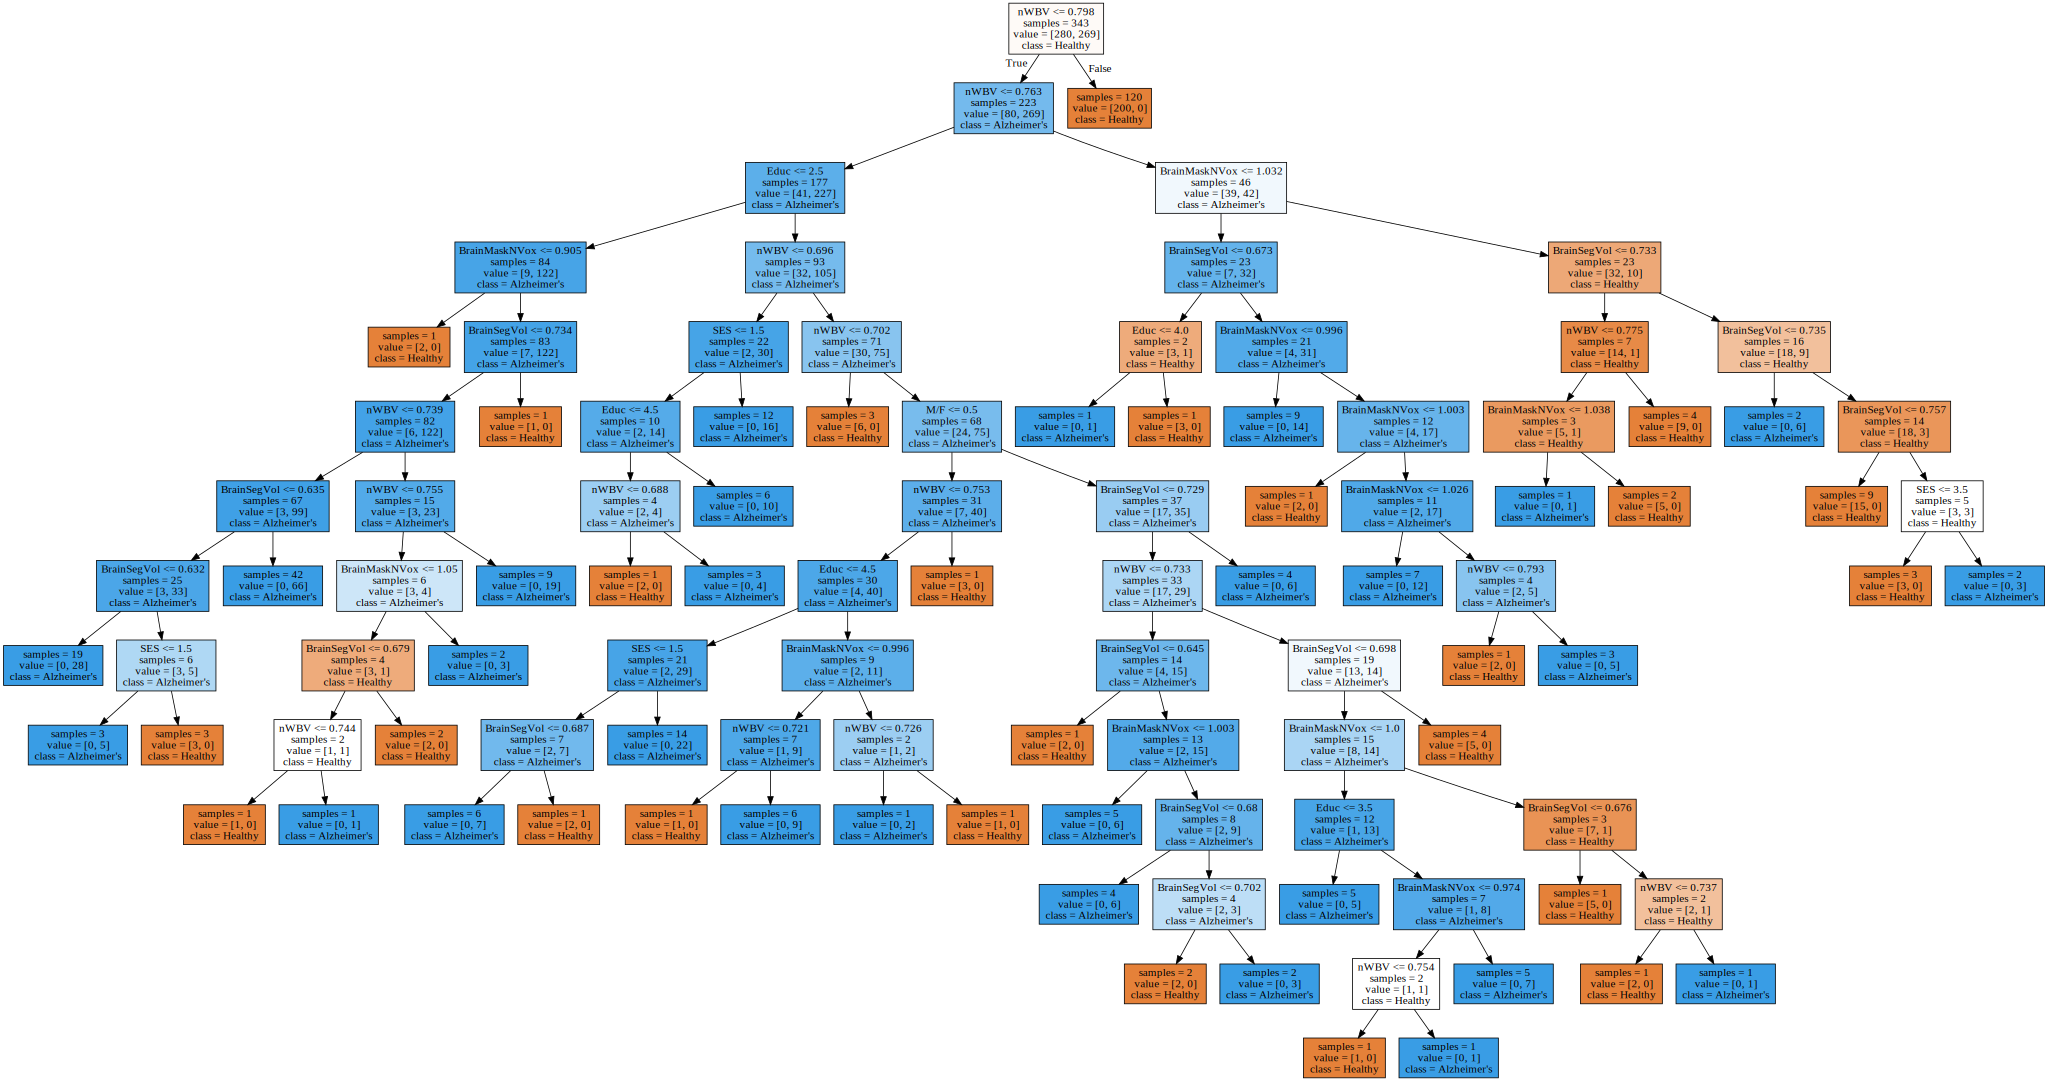

In [291]:
tree = export_graphviz(estimator, out_file=None, 
                class_names=["Healthy", "Alzheimer's"], 
                feature_names=['BrainMaskNVox','BrainSegVol','M/F','Educ','SES','nWBV'],
                impurity=False,
                filled=True)

graph = graphviz.Source(tree)
graph.render('DecTree')  # creates PDF
graph  # in Jupyter

## Results

In [292]:
result_df = pd.DataFrame({
    'Model': ['NN','T-SNE + NN','PCA + NN','Demographic Data + RF'],
    'Accuracy': [model_accuracy,tsne_accuracy,PCA_accuracy, RF_txt_vol_accuracy],
    'Precision': [model_precision,tsne_precision,PCA_precision, RF_txt_vol_precision],
    'Recall': [model_recall,tsne_recall,PCA_recall, RF_txt_vol_recall]
 })
result_df = result_df.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Precision,Recall
Model,,,
Demographic Data + RF,95.63,91.21,100.00
PCA + NN,94.01,91.11,97.62
T-SNE + NN,89.82,86.02,95.24
NN,88.62,85.71,92.86


In [293]:
result_df.style.background_gradient(cmap='GnBu', low=1, high=0.75, axis=0).set_properties(**{'font-size':'15pt'})

,Accuracy,Precision,Recall
Model,,,
Demographic Data + RF,95.63,91.21,100
PCA + NN,94.01,91.11,97.62
T-SNE + NN,89.82,86.02,95.24
NN,88.62,85.71,92.86
